Test of Richardson-Lucy Deconvolution python implementation
-----------
This notebook does a qualitative test of the implementation of Richardson-Lucy from Justin Ely. 
It also tests there is some hope of simply deconvolving the low-resolution PSF by the high-resolution to construct the matching kernel.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import convolution
from scipy import stats
import lucy
from skimage import restoration, measure
import photutils
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

First, create a PSF and an image

In [50]:
psf = convolution.Gaussian2DKernel(5.).array
#plt.imshow(psf.array,cmap=plt.cm.viridis)
#psf.array.sum()
#psf = psf.array

In [51]:
img = np.zeros((128,128),dtype='float64')
img[64,64] = 1
img[32,32] = 0.5
#plt.imshow(img,cmap=plt.cm.viridis)

Convolve the image with the PSF...add some Poisson noise

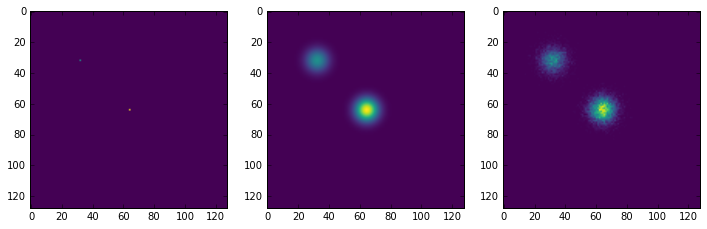

In [52]:
cimg = convolution.convolve(img,psf)*10000
pcimg = stats.poisson(cimg).rvs()
plt.subplot(131)
plt.imshow(img,cmap=plt.cm.viridis)
plt.subplot(132)
plt.imshow(cimg,cmap=plt.cm.viridis)
plt.subplot(133)
plt.imshow(pcimg,cmap=plt.cm.viridis)

Now Deconvolve the image

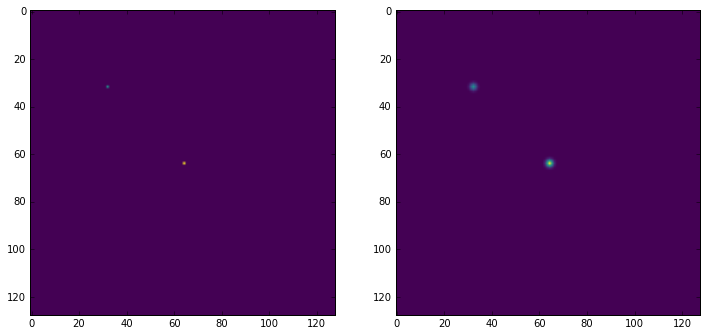

In [53]:
dcimg1 = lucy.rl_standard(cimg,psf,400)
plt.subplot(121)
plt.imshow(img,cmap=plt.cm.viridis)
plt.subplot(122)
plt.imshow(dcimg1,cmap=plt.cm.viridis)

Looks good. Now test whether we can construct a matching kernel just by deconvolving the high-resolution PSF by the low resolution PSF. 

In [54]:
psf1=convolution.Gaussian2DKernel(3.,x_size=65,y_size=65,mode='oversample').array
psf2=convolution.Gaussian2DKernel(8.5,x_size=65,y_size=65,mode='oversample').array

In [56]:
s1 = photutils.morphology.data_properties(psf1,mask=None)
s2 = photutils.morphology.data_properties(psf2,mask=None)
print "s1sigma ",s1.semimajor_axis_sigma,s1.semiminor_axis_sigma
print "s2sigma ",s2.semimajor_axis_sigma,s2.semiminor_axis_sigma

s1sigma  3.01371863318 pix 3.01371863318 pix
s2sigma  8.49615741928 pix 8.49615741928 pix


In [57]:
kernel = lucy.rl_standard(psf2,psf1,100)
#plt.imshow(kernel,cmap=plt.cm.viridis)
sk = photutils.morphology.data_properties(kernel,mask=None)
print "kernelsigma ",sk.semimajor_axis_sigma,sk.semiminor_axis_sigma

kernelsigma  7.9422904684 pix 7.9422904684 pix


matchedsigma  8.49145952632 pix 8.49145952632 pix


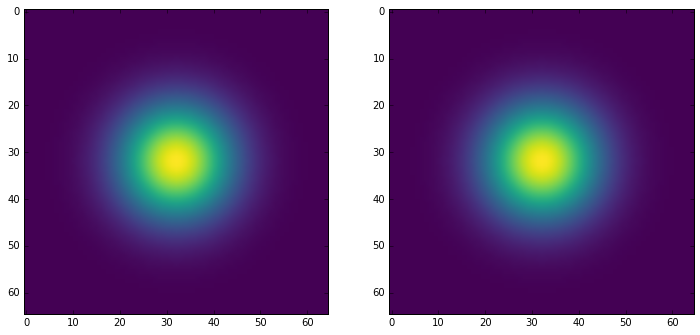

In [58]:
matched = convolution.convolve(psf1,kernel)
plt.subplot(121)
plt.imshow(psf2,cmap=plt.cm.viridis)
plt.subplot(122)
plt.imshow(matched,cmap=plt.cm.viridis)
sm = photutils.morphology.data_properties(matched,mask=None)
print "matchedsigma ",sm.semimajor_axis_sigma,sm.semiminor_axis_sigma

Conclusion
-----
The code seems to work. And using this to construct a kernel looks pretty promising.